In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import argrelmax, argrelmin

In [5]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth.h5'

hdf5_modis = h5py.File(path_hdf5, 'r')

In [3]:
wht = hdf5_modis['whittaker']

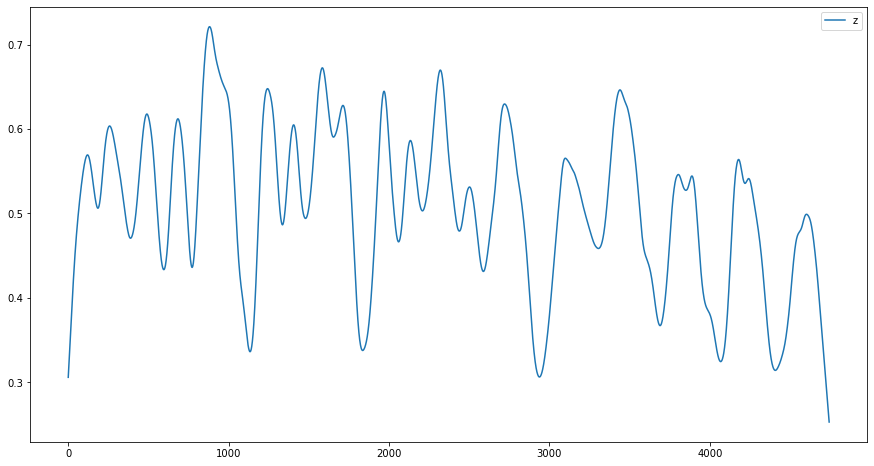

In [4]:
# plot time series of pixel
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(wht[650,905,:], label='z')
ax.legend()

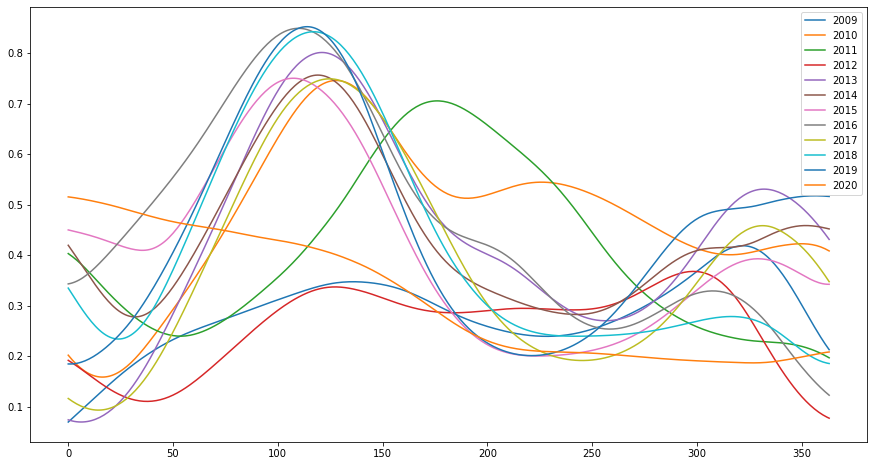

In [5]:
x = 0
y = 365
#z = wht[0,157,:]
z = wht[30,1256,:]
#z = wht[930,520,:]
#z = wht[910,510,:]

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(z[x+1:x+y], label='2009')
ax.plot(z[x+y*1+1:x+y*2], label='2010')
ax.plot(z[x+y*2+1:x+y*3], label='2011')
ax.plot(z[x+y*3+1:x+y*4], label='2012')
ax.plot(z[x+y*4+1:x+y*5], label='2013')
ax.plot(z[x+y*5+1:x+y*6], label='2014')
ax.plot(z[x+y*6+1:x+y*7], label='2015')
ax.plot(z[x+y*7+1:x+y*8], label='2016')
ax.plot(z[x+y*8+1:x+y*9], label='2017')
ax.plot(z[x+y*9+1:x+y*10], label='2018')
ax.plot(z[x+y*10+1:x+y*11], label='2019')
ax.plot(z[x+y*11+1:x+y*12], label='2020')
ax.legend()

In [6]:
def clip_years(arr, start_year, end_year, offset=0):
    
    x = 0
    y = 365

    pixel = {}

    for i in range(0,end_year-start_year):
        pixel[start_year+i] = np.array(arr[x+y*i+1+offset:x+y*(i+1)+offset])
        
    return pixel

In [46]:
def get_pheno_sos(pixel, year):
    
    if pixel[year].all() == 0:
        return -1, -1, 0
    
    else:
        try:
            # find index of 20% -> SOS

            # get all maxima
            idxs_max = argrelmax(pixel[year])[0]
            # get number of maxima
            nr_max = idxs_max.size

            # no maxima found
            if nr_max == 0:
                idx_max = np.argmax(pixel[year])
                if idx_max < 10:
                    return -1, -1, 0
                else:
                    nr_max = 1
            # one maximum found
            elif nr_max == 1:
                # get the maximum of the season
                idx_max = idxs_max[0]
            # more maxima found
            elif nr_max > 1:
                for idx_m in idxs_max:

                    if np.absolute(pixel[year][idx_m]) >= np.absolute(np.max(pixel[year])*0.4):
                        idx_max = idx_m
                        break

                    return -1, -1, 0

            # get maximum value
            maximum = pixel[year][idx_max]

            # get minimum in beginning of the season
            idx_min = np.argmin(pixel[year][:idx_max])
            minimum = pixel[year][idx_min]

            # calculate SOS
            pix_20 = (maximum-minimum)*0.2 + minimum

            # find index (days since the beginning of the year) of SOS
            idx_20 = (np.abs(pixel[year][idx_min:idx_max] - pix_20)).argmin() + idx_min

            return idx_20, idx_max, nr_max
        
        except:
            return -2, -2, 0

In [81]:
def get_pheno_eos(pixel, year, idx_max, offset=0):
    
    if (pixel[year].all() == 0) | (idx_max == -1):
        return -1
    
    else:
        try:
            #print(offset, idx_max)
            idx_max -= offset

            # find index of 20% -> EOS
            idx_min = np.argmin(pixel[year][idx_max:]) + idx_max
            #print(idx_max, idx_min)

            # get maximum value
            minimum = pixel[year][idx_min]
            maximum = pixel[year][idx_max]

            # calculate SOS
            pix_20 = (maximum-minimum)*0.2 + minimum

            # find index (days since the beginning of the year) of SOS
            idx_20 = (np.abs(pixel[year][idx_max:idx_min] - pix_20)).argmin() + idx_max
            #print(idx_max + offset, idx_20 + offset, idx_min + offset)
            
            return idx_20 + offset
        
        except:
            return -1

In [9]:
start_year = 2009
end_year = 2021

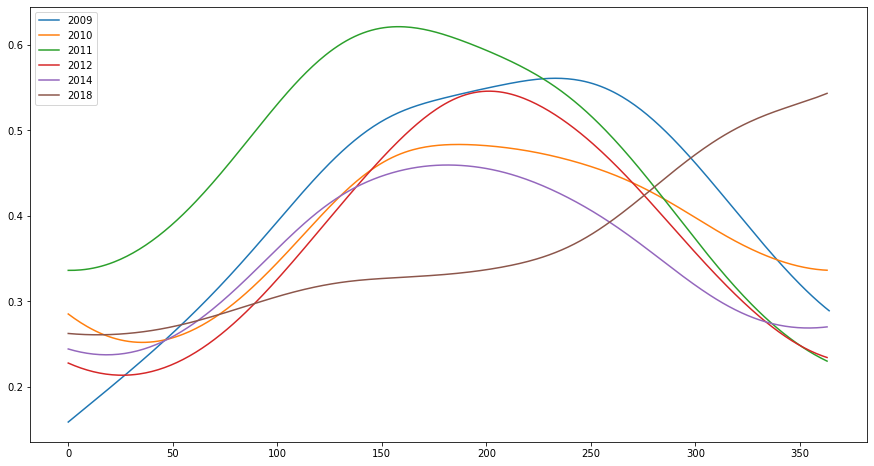

In [77]:
x = 0
y = 365

a = 7
b = 1515
# plot time series of pixel
#z = wht[0,157,:]
z = wht[a,b,:]
#z = wht[930,520,:]
#z = wht[910,510,:]

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(z[x*1:x+y*1], label='2009')
ax.plot(z[x+y*1+1:x+y*2], label='2010')
ax.plot(z[x+y*2+1:x+y*3], label='2011')
ax.plot(z[x+y*3+1:x+y*4], label='2012')
ax.plot(z[x+y*5+1:x+y*6], label='2014')
ax.plot(z[x+y*9+1:x+y*10], label='2018')
ax.legend()

In [54]:
year = 2013

pixel = clip_years(z, start_year, end_year, offset=0)

idx_20, idx_max, nr_max = get_pheno_sos(pixel, year)
print(idx_20, idx_max, nr_max)

96 198 1


In [63]:
year = 2014

idxs_max = np.unique(hdf5_modis['MOS'][a,b,:])
print(idxs_max)

try:
    if idxs_max[0] == -1:
        offset = idxs_max[1]
    else:
        offset = idxs_max[0]
except:
    offset = 0
print(offset)

idx_max = np.unique(hdf5_modis['MOS'][a,b,int(year-start_year)])[0]
print(idx_max)

pixel = clip_years(z, start_year, end_year, offset=offset)

idx_20 = get_pheno_eos(pixel, year, idx_max, offset)
print(idx_20)

[ 83 184 198 209 216 219 223 230 233 240]
83
216
304


In [3]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth_eos.h5'

# create / open file
hdf5_modis_eos = h5py.File(path_hdf5, 'a')

In [47]:
typ = 'SOS'

# y-coordinates
for y in range(hdf5_modis['whittaker'].shape[0]):
    print(y)
    # x-coordinates
    for x in range(hdf5_modis['whittaker'].shape[1]):
        #print(x)

        pixel = clip_years(hdf5_modis['whittaker'][y,x,:], start_year, end_year, offset=0)
            
        # years
        for year in range(start_year, end_year):
            #print(year)
            
            # SOS
            hdf5_modis_eos['SOS'][y,x,year-start_year], \
            hdf5_modis_eos['MOS'][y,x,year-start_year], \
            hdf5_modis_eos['peaks'][y,x,year-start_year] = get_pheno_sos(pixel, year)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [82]:
typ = 'EOS'

# y-coordinates
for y in range(7,hdf5_modis['whittaker'].shape[0]):
    print(y)
    # x-coordinates
    for x in range(hdf5_modis['whittaker'].shape[1]):
        #print(x)
        
        idxs_max = np.unique(hdf5_modis_eos['MOS'][y,x,:])
        
        try:
            if idxs_max[0] == -1:
                offset = idxs_max[1]
            else:
                offset = idxs_max[0]
        except:
            offset = 0
            
        pixel = clip_years(hdf5_modis['whittaker'][y,x,:], start_year, end_year, offset=offset)
            
        # years
        for year in range(start_year, end_year):
            #print(year)
            
            idx_max = hdf5_modis_eos['MOS'][y,x,year-start_year]
            # SOS
            hdf5_modis_eos['EOS'][y,x,year-start_year] = get_pheno_eos(pixel, year, idx_max, offset=offset)

7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280


In [6]:
typ = 'LOS'

# y-coordinates
for y in range(hdf5_modis['whittaker'].shape[0]):
    print(y)
    # x-coordinates
    for x in range(hdf5_modis['whittaker'].shape[1]):
        #print(x)
        for year in range(11, 12):
            #print(year)
            
            idxs_sos = np.unique(hdf5_modis_eos['SOS'][y,x,year])
            idxs_eos = np.unique(hdf5_modis_eos['EOS'][y,x,year])

            if (idxs_sos == -1) | (idxs_eos == -1):
                hdf5_modis_eos['LOS'][y,x,year] = -1
            else:
                hdf5_modis_eos['LOS'][y,x,year] = idxs_eos - idxs_sos
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [90]:
year-start_year

11

In [25]:
hdf5_modis_eos['MOS'][0,750]

array([202, 184, 204, 185, 200, 185, 195, 192,   2, 186, 192, 193],
      dtype=int16)

In [7]:
hdf5_modis_eos.close()

In [92]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth_eos.h5'

# create / open file
hdf5_modis_eos = h5py.File(path_hdf5, 'a')

if not os.path.isfile(path_hdf5):
    print('file not found -> creating file')
    
# create dataset
hdf5_modis_eos.create_dataset('peaks',\
                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
                       (end_year-start_year)), dtype=np.int16)
                       
# create dataset
hdf5_modis_eos.create_dataset('SOS',\
                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
                       (end_year-start_year)), dtype=np.int16)

# create dataset
hdf5_modis_eos.create_dataset('MOS',\
                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
                       (end_year-start_year)), dtype=np.int16)

# create dataset
hdf5_modis_eos.create_dataset('EOS',\
                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
                       (end_year-start_year)), dtype=np.int16)

# create dataset
hdf5_modis_eos.create_dataset('LOS',\
                       (hdf5_modis['whittaker'].shape[0], hdf5_modis['whittaker'].shape[1],\
                       (end_year-start_year)), dtype=np.int16)

<HDF5 dataset "LOS": shape (1299, 1864, 12), type "<i2">

In [93]:
hdf5_modis_eos.keys()

<KeysViewHDF5 ['EOS', 'LOS', 'MOS', 'SOS', 'peaks']>